# Setup

## Effect of blooming bacteria on Bray-Curtis distance
### Supplementary figure 1

In this Notebook, we test the effect of removing bloom sequences and the impact in beta diversity as measured by Bray Curtis distance. To do so, we're going to compare samples from four studies, the American Gut Project (AGP; Qiita ID [10317](https://qiita.ucsd.edu/study/description/10317)), the Personal Genome Project microbiome samples (PGP; Qiita ID [1189](https://qiita.ucsd.edu/study/description/1189)), the Human Genetics Shape the Gut Microbiome dataset (Twins UK; Qiita ID [2014](https://qiita.ucsd.edu/study/description/2014)) and samples from a whole grain diet study (ERC; Qiita ID [1481](https://qiita.ucsd.edu/study/description/1481)).

Samples in the AGP study are shipped at room temperature. The other three studies were fresh-frozen. Our expectation is that the filtering will reduce distances between the American Gut vs. fresh-frozen studies, while the distances between fresh-frozen studies will change comparably less. The expectation is based on the assumption that the blooms have a higher impact on the American Gut data stemming from room temperature shipping.

Specifically, we:

1. Load the study datasets
2. For an increasing number of bloom sequences (starting with zero blooms, and sorted by decreasing severity):
    1. Filter out the bloom sequences
    2. Rarefy to 1000 sequences per sample
    3. Randomly select 1000 samples from each study (with replacement)
    4. Calculate the Bray-Curtis distance for:
        - AGP vs. PGP
        - AGP vs. Twins UK
        - AGP vs. ERC
        - Twins UK vs. PGP
        - ERC vs. Twins UK
        - ERC vs. PGP

3. Plot the result.

In [1]:
# plots inside the notebook
%matplotlib notebook

# load modules used in the analysis
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import biom
import pandas as pd
import skbio
from scipy.spatial.distance import braycurtis

In [2]:
def sniff_category(metadata_path):
    """Determine which category describes fecal
    
    The metadata are not 100% consistent on category and value used
    to describe a fecal sample.
    """
    sniff = open(metadata_path).read().strip().split('\t')
    if 'ENV_MATTER' in sniff:
        key = 'ENV_MATTER'
        value = 'ENVO:feces'
    elif 'env_matter' in sniff:
        key = 'env_matter'
        value = 'ENVO:feces'
    elif 'env_material' in sniff:
        key = 'env_material'
        value = 'feces'
    else:
        raise KeyError("No interpretable column for denoting fecal")
        
    return key, value


def load(table_path, metadata_path):
    """Load a study, filter to fecal, drop samples with < 1000 reads"""
    key, value = sniff_category(metadata_path)
    
    # load the biom table and remove any sample that does not contain reads
    table = biom.load_table(table_path)
    table.filter(lambda v, i, md: v.sum() > 0)  # drop samples without data
    
    # load metadata, set the index to the samples
    metadata = pd.read_csv(metadata_path, sep='\t', dtype=object, usecols=['#SampleID', key])
    metadata.set_index('#SampleID', inplace=True)
   
    # verify we have information about all samples
    assert set(table.ids()).issubset(metadata.index)
    
    # reduce to the fecal subset
    fecal_metadata = metadata[metadata[key] == value]
    fecal_metadata = fecal_metadata.loc[set(fecal_metadata.index) & set(table.ids())]
    
    # subset to fecal, keep samples with >= 1000 reads, and remove any empty OTUs
    table.filter(fecal_metadata.index)
    table.filter(lambda v, i, md: v.sum() >= 1000)
    table.filter(lambda v, i, md: v.sum() > 0, axis='observation')
    
    # reduce the metadata to only the samples represented
    fecal_metadata = fecal_metadata.loc[table.ids()]
    
    # normalize metadata (we already filtered to fecal based on study specific values)
    fecal_metadata.columns = ['ENV_MATTER']
    fecal_metadata['ENV_MATTER'] = 'feces'
    
    print("Fecal samples: %d" % len(table.ids()))
    
    return table, fecal_metadata

# Loading all experimental data

In [3]:
ag_table, ag_metadata       = load('../data/ag.qiita-10317.biom',   '../data/ag.qiita-10317.txt')
twins_table, twins_metadata = load('../data/twins.qiita-2014.biom', '../data/twins.qiita-2014.txt')
pgp_table, pgp_metadata     = load('../data/pgp.qiita-1189.biom',   '../data/pgp.qiita-1189.txt')
erc_table, erc_metadata     = load('../data/erc.qiita-1481.biom',   '../data/erc.qiita-1481.txt')

Fecal samples: 7073
Fecal samples: 1017
Fecal samples: 82
Fecal samples: 88


## Join all data into a single table and data frame


In [4]:
table = pgp_table.merge(erc_table).merge(twins_table).merge(ag_table)
metadata = pd.concat([pgp_metadata, erc_metadata, twins_metadata, ag_metadata])

assert set(table.ids()) == set(metadata.index)

print("Total number of sOTUs: %d\nTotal number of samples: %d" % table.shape)

Total number of sOTUs: 17357
Total number of samples: 8260


## Calculate the mean Bray-Curtis distance for filtering levels

Remove incrementally more blooms, starting from the most severe to least severe, and at each increment, compute the Bray Curtis distance between random sets of samples within each study.

In [5]:
def sample_and_remap(df, iterations, index, tag):
    """Sample with replacement from df, return the observed index positions"""
    # determine what IDs are still in the table
    valid = set(index).intersection(df.index)
    
    # randomly sample with replacement over the IDs
    ids = df.loc[valid].sample(iterations, replace=True).index.values
    
    # determine their index position in the matrix
    indices = [index[i] for i in ids]
    
    if len(df) - len(valid):
        print("  %s - %d sample(s) did not pass filtering" % (tag, len(df) - len(valid)))

    return indices 

# initial conditions
iterations = 1000
sequences = list(skbio.read('../data/newbloom.all.fa', format='fasta'))

# datasets to store the resulting bray curtis distances
ag_vs_twin  = np.zeros((len(sequences) + 1, iterations))
ag_vs_pgp   = np.zeros((len(sequences) + 1, iterations))
ag_vs_erc   = np.zeros((len(sequences) + 1, iterations))
pgp_vs_twin = np.zeros((len(sequences) + 1, iterations))
erc_vs_twin = np.zeros((len(sequences) + 1, iterations))
erc_vs_pgp  = np.zeros((len(sequences) + 1, iterations))

blooms = set()
for bloom_idx in range(len(sequences) + 1):
    # make sure we run once without any blooms
    if bloom_idx > 0:
        blooms.add(str(sequences[bloom_idx - 1]))
        
    print("Operating on %d bloom(s)..." % len(blooms))
    
    # remove bloom sequences, rarefy, normalize to [0, 1], and fetch a dense representation
    table_wo_blooms = table.filter(blooms, invert=True, inplace=False, axis='observation')
    table_wo_blooms = table_wo_blooms.subsample(1000).norm()
    table_wo_blooms_mat = table_wo_blooms.matrix_data.T.toarray()
    
    # compute an index mapping each ID to a row in the matrix
    index = {i: idx for idx, i in enumerate(table_wo_blooms.ids())}
    
    # get a bunch of random positions in the matrix for each study
    ag_samples    = sample_and_remap(ag_metadata, iterations, index, 'AG') 
    pgp_samples   = sample_and_remap(pgp_metadata, iterations, index, 'PGP')
    erc_samples   = sample_and_remap(erc_metadata, iterations, index, 'ERC')
    twins_samples = sample_and_remap(twins_metadata, iterations, index, 'Twins')
    
    # pull out the matrix of counts corresponding to the random positions
    ag_counts    = table_wo_blooms_mat[ag_samples]
    pgp_counts   = table_wo_blooms_mat[pgp_samples]
    erc_counts   = table_wo_blooms_mat[erc_samples]
    twins_counts = table_wo_blooms_mat[twins_samples]
    
    # compute bray curtis
    ag_vs_twin[bloom_idx]  = np.array([braycurtis(u, v) for u, v in zip(ag_counts, twins_counts)])
    ag_vs_pgp[bloom_idx]   = np.array([braycurtis(u, v) for u, v in zip(ag_counts, pgp_counts)])
    ag_vs_erc[bloom_idx]   = np.array([braycurtis(u, v) for u, v in zip(ag_counts, erc_counts)])
    pgp_vs_twin[bloom_idx] = np.array([braycurtis(u, v) for u, v in zip(pgp_counts, twins_counts)])
    erc_vs_twin[bloom_idx] = np.array([braycurtis(u, v) for u, v in zip(erc_counts, twins_counts)])
    erc_vs_pgp[bloom_idx]  = np.array([braycurtis(u, v) for u, v in zip(erc_counts, pgp_counts)])

Operating on 0 bloom(s)...
Operating on 1 bloom(s)...
  AG - 3 sample(s) did not pass filtering
Operating on 2 bloom(s)...
  AG - 6 sample(s) did not pass filtering
Operating on 3 bloom(s)...
  AG - 7 sample(s) did not pass filtering
Operating on 4 bloom(s)...
  AG - 11 sample(s) did not pass filtering
Operating on 5 bloom(s)...
  AG - 75 sample(s) did not pass filtering
Operating on 6 bloom(s)...
  AG - 78 sample(s) did not pass filtering
Operating on 7 bloom(s)...
  AG - 78 sample(s) did not pass filtering
Operating on 8 bloom(s)...
  AG - 102 sample(s) did not pass filtering
Operating on 9 bloom(s)...
  AG - 109 sample(s) did not pass filtering
Operating on 10 bloom(s)...
  AG - 117 sample(s) did not pass filtering
Operating on 11 bloom(s)...
  AG - 117 sample(s) did not pass filtering
Operating on 12 bloom(s)...
  AG - 117 sample(s) did not pass filtering
Operating on 13 bloom(s)...
  AG - 122 sample(s) did not pass filtering
Operating on 14 bloom(s)...
  AG - 126 sample(s) did not

<IPython.core.display.Javascript object>


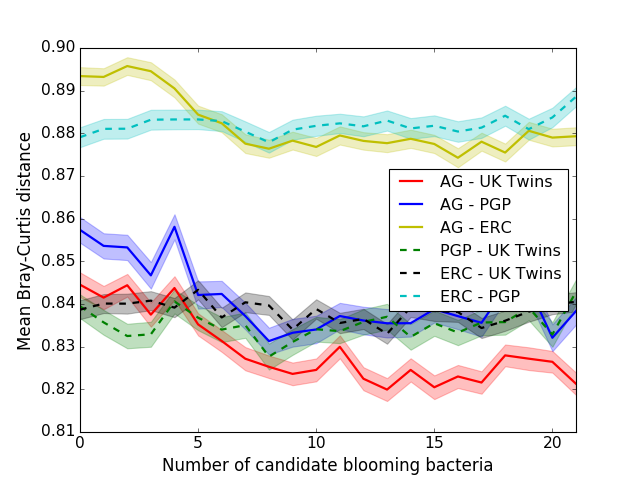

In [6]:
def plot_comparison(results, color, against_ag):
    """Plot mean and stderr for the values in results"""
    n_blooms, iterations = results.shape
    x_axis = np.arange(n_blooms)
    
    results_mean = results.mean(axis=1)
    results_stderr = results.std(axis=1) / np.sqrt(iterations)
    
    plt.fill_between(x_axis, 
                     results_mean + results_stderr, 
                     results_mean - results_stderr, 
                     alpha=0.25, color=color)
    
    linestyle = '-' if against_ag else '--'
    plt.plot(x_axis, results_mean, color=color, lw=2, linestyle=linestyle)

plt.figure()
plot_comparison(ag_vs_twin, 'r', True)
plot_comparison(ag_vs_pgp, 'b', True)
plot_comparison(ag_vs_erc, 'y', True)
plot_comparison(pgp_vs_twin, 'g', False)
plot_comparison(erc_vs_twin, 'k', False)
plot_comparison(erc_vs_pgp, 'c', False)

plt.legend(['AG - UK Twins',
            'AG - PGP',
            'AG - ERC',
            'PGP - UK Twins',
            'ERC - UK Twins',
            'ERC - PGP'], loc='center right')
plt.xlabel('Number of candidate blooming bacteria', fontsize=15)
plt.ylabel('Mean Bray-Curtis distance', fontsize=15)
plt.xlim(0, len(ag_vs_twin) - 1)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)